In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../")

In [4]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

sns.set_style("whitegrid")

# TriviaQA

In [6]:
from pathlib import Path

dataset = "trivia_qa"

activation_dirs = {
    "llama": Path(f"../data/activations/{dataset}/llama_3.1_8b_instruct/sampling_high_temp_with_activations__prompt_qa/short_few_shot_sep__seed_42/activations"),
    "mistral": Path(f"../data/activations/{dataset}/mistral_0.3_7b_instruct/sampling_high_temp_with_activations__prompt_qa/short_few_shot_sep__seed_42/activations"),
}

all_shards_paths = {
    k: list((v.glob("*.pt")))
    for k, v in activation_dirs.items()
}

In [7]:
from tqdm.notebook import tqdm
from hallucinations.metrics.common import normalize
from collections import defaultdict

eigvals = defaultdict(lambda: defaultdict(list))
layer_idx = [8, 16, 24, 32]
y

for model, shards_paths in all_shards_paths.items():
    print(f"Processing {model}...")
    for shard_path in tqdm(shards_paths):
        shard = torch.load(shard_path, weights_only=True, mmap=True, map_location="cpu")
        for idx in layer_idx:
            layer_hstates = shard["hidden_states"][idx]
            for example_hstate in layer_hstates:
                with torch.no_grad():
                    example_hstate = example_hstate.to(torch.float32).to(device)
                    A = torch.cov(normalize(example_hstate))
                    S = torch.linalg.svdvals(A / torch.trace(A))
                eigvals[model][idx].append(S)
    torch.cuda.empty_cache()

Processing llama...


  0%|          | 0/121 [00:00<?, ?it/s]

Processing mistral...


  0%|          | 0/121 [00:00<?, ?it/s]

In [31]:
eigvals["mistral"].keys()


dict_keys([8, 16, 24, 32])

In [33]:
eigvals["mistral"][8].shape

torch.Size([3842, 360])

In [11]:
# Move all tensors to CPU
for model in eigvals:
    for layer in eigvals[model]:
        eigvals[model][layer] = [tensor.cpu() for tensor in eigvals[model][layer]]

torch.cuda.empty_cache()


In [12]:
from copy import deepcopy

eigvals_copy = deepcopy(eigvals)

In [44]:
# for model, evs in eigvals_copy.items():
#     torch.save(evs, f"eigvals_{model}.pt")


In [7]:
# load eigvals
eigvals = {}
for model in ["mistral", "llama"]:
    eigvals[model] = torch.load(f"eigvals_{model}.pt")


/tmp/ipykernel_1243771/176128415.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eigvals[model] = torch.load(f"eigvals_{model}.pt")


In [8]:
for model, model_eigvals in eigvals.items():
    for idx, layer_eigvals in model_eigvals.items():
        max_dim = max(tensor.shape[0] for tensor in layer_eigvals)

        # Pad each tensor to max_dim with zeros
        padded_tensors = []
        for tensor in layer_eigvals:
            if tensor.shape[0] < max_dim:
                padding = torch.zeros(max_dim - tensor.shape[0])
                padded_tensor = torch.cat([tensor, padding])
            else:
                padded_tensor = tensor
            padded_tensors.append(padded_tensor)

        # Stack the padded tensors
        eigvals[model][idx] = torch.vstack(padded_tensors)

In [9]:
import json

from hallucinations.utils.metric_loader import compute_model_results

model_answers = []

for model, act_dir in activation_dirs.items():
    ans_path = act_dir.parent / "answers.json"
    with open(ans_path, "r") as f:
        answers = json.load(f)
    model_answers.append({"answers": answers, "model": model})

model_results = {x["model"]: x for x in compute_model_results(model_answers)}

Evaluating ROUGE metrics: 100%|██████████| 3842/3842 [00:00<00:00, 7316.61it/s]


In [10]:
df_list = []

for model, model_eigvals in eigvals.items():
    for idx, layer_eigvals in model_eigvals.items():
        df = pd.DataFrame(layer_eigvals)
        df["hallucinated"] = model_results[model]["labels"]
        df["layer"] = idx
        df["model"] = model
        df_list.append(df)

df = pd.concat(df_list, axis=0)

In [11]:
layer_eigvals.shape

torch.Size([3842, 347])

In [12]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,hallucinated,layer,model
0,0.579755,0.138819,0.038391,0.021609,0.012688,0.010959,0.010021,0.008557,0.007485,0.006895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,mistral
1,0.579980,0.145258,0.025345,0.015043,0.011942,0.011002,0.008710,0.007759,0.007356,0.006605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,mistral
2,0.587948,0.093602,0.025368,0.015685,0.011042,0.010192,0.009071,0.008473,0.007573,0.007461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,mistral
3,0.582006,0.121978,0.058884,0.021919,0.012756,0.010690,0.009335,0.008446,0.007307,0.006906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,mistral
4,0.581270,0.134898,0.059061,0.020665,0.011842,0.010690,0.008654,0.008059,0.006987,0.006808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8,mistral


In [13]:
df_melted = df.melt(
    id_vars=["hallucinated", "layer", "model"],
    value_vars=[i for i in range(df.shape[1] - 3)],
    var_name="eigval",
    value_name="value",
)
df_melted.head()

,hallucinated,layer,model,eigval,value
0,0,8,mistral,0,0.579755
1,0,8,mistral,0,0.579980
2,0,8,mistral,0,0.587948
3,0,8,mistral,0,0.582006
4,1,8,mistral,0,0.581270


In [14]:
df_melted["value"].isna().sum()

199784

In [15]:
# is zero sum
df_melted[df_melted["value"] == 0.].shape


(4167943, 5)

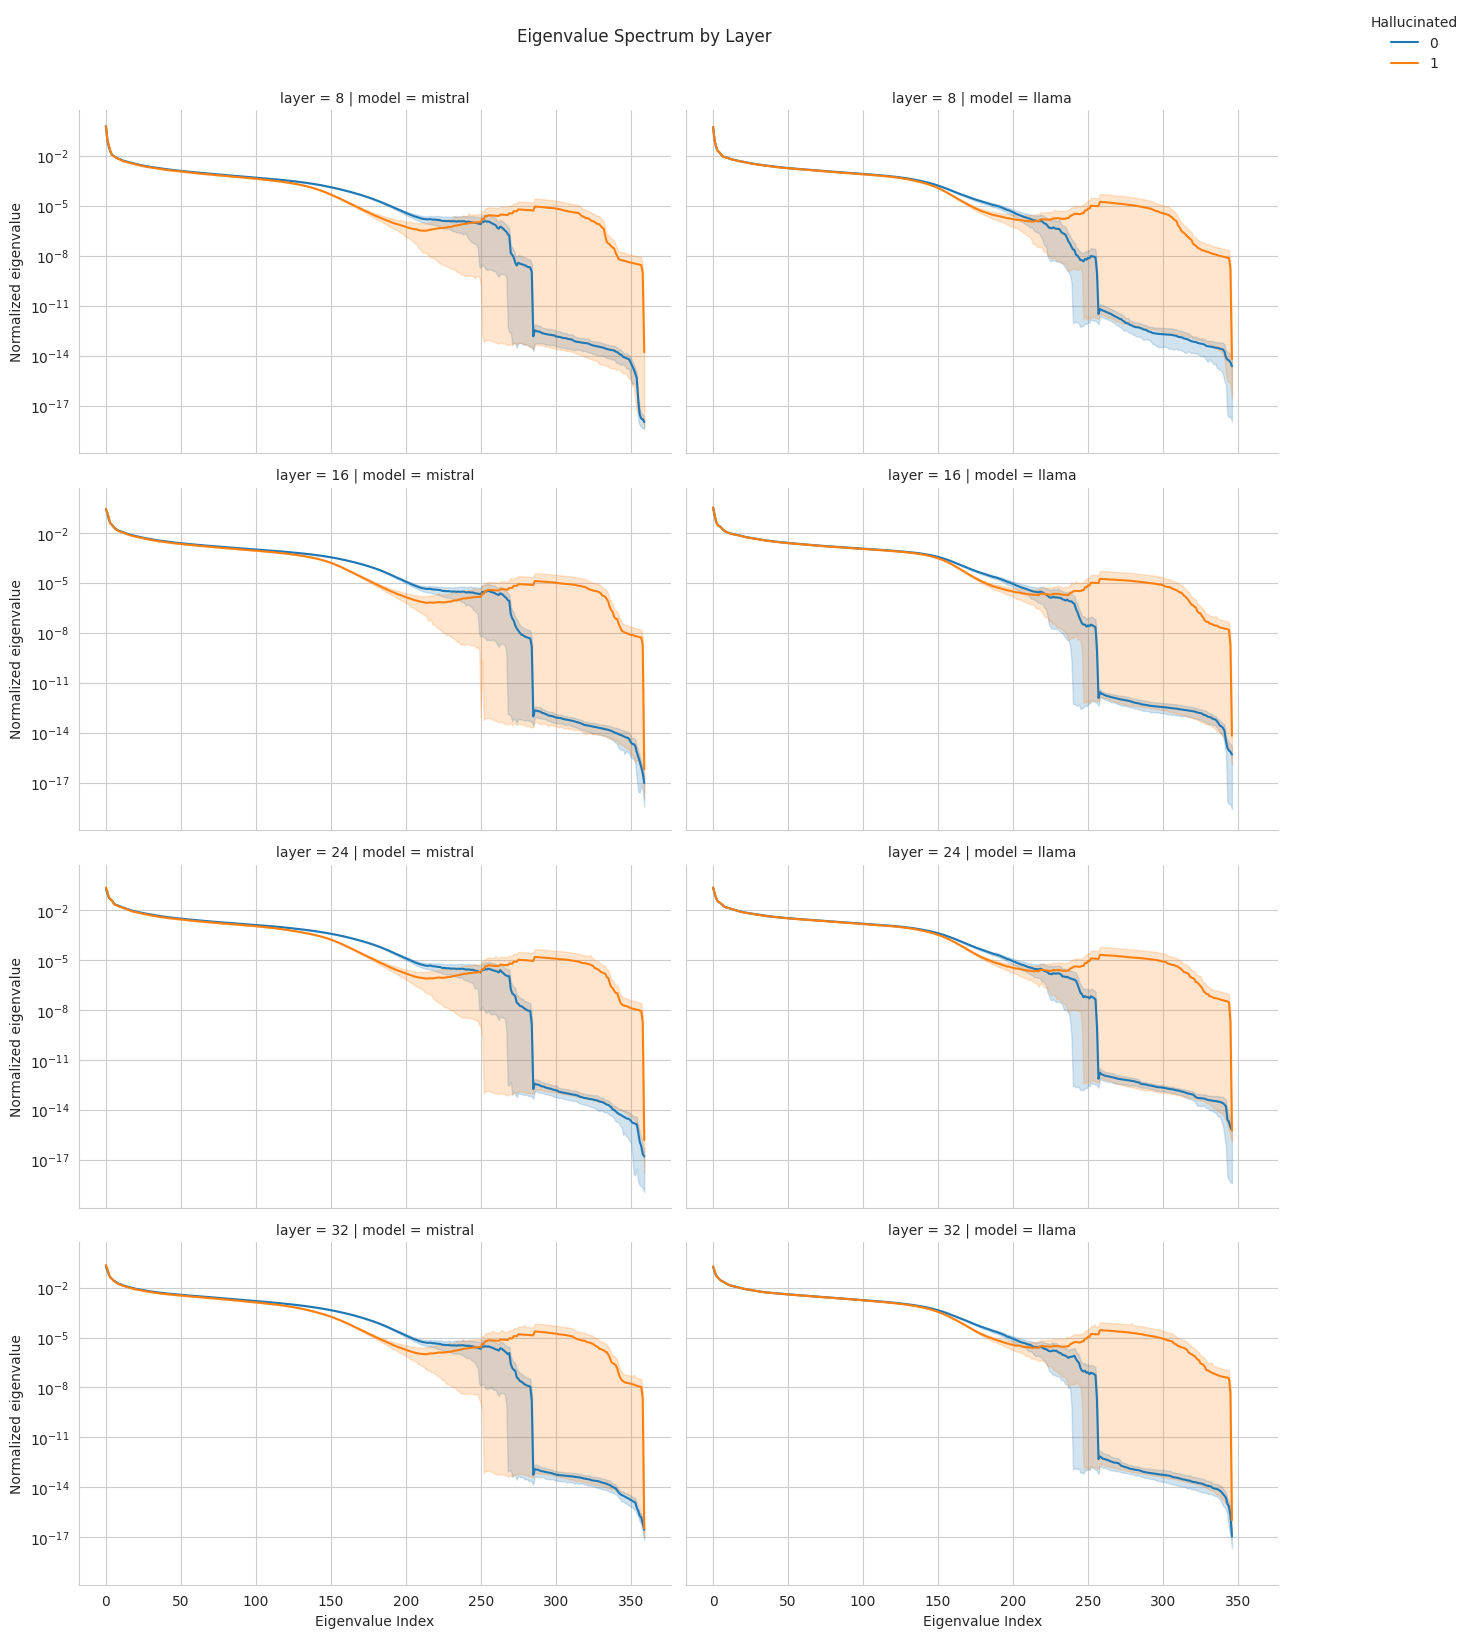

In [16]:
df_plot = df_melted[df_melted["value"] != 0.0]
df_plot = df_plot[df_plot["value"].notna()]

g = sns.FacetGrid(df_plot, row="layer", col="model", height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x="eigval", y="value", hue="hallucinated")

g.set_axis_labels("Eigenvalue Index", "Normalized eigenvalue")
for ax in g.axes.flat:
    ax.set_yscale("log")
    ax.grid(True)
g.fig.suptitle("Eigenvalue Spectrum by Layer", y=1.01)
g.add_legend(title="Hallucinated", bbox_to_anchor=(1.05, 1), loc="center left")
plt.tight_layout()


# AUROC

In [64]:
import math
from tqdm.notebook import tqdm
from collections import defaultdict

eranks = {}


for model, model_eigvals in eigvals.items():
    print(f"Processing {model}...")
    eranks[model] = defaultdict(list)
    for idx, layer_eigvals in tqdm(model_eigvals.items()):
        for sample_eigvals in layer_eigvals:
            erank = -(sample_eigvals * torch.log(sample_eigvals)).nansum().item()
            erank = math.exp(erank)
            eranks[model][idx].append(erank)


Processing mistral...


  0%|          | 0/4 [00:00<?, ?it/s]

Processing llama...


  0%|          | 0/4 [00:00<?, ?it/s]

In [66]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Compute AUROC scores for eranks and tail contributions
auroc_scores = {}
tail_auroc_scores = {}

for model in eranks:
    auroc_scores[model] = {}
    tail_auroc_scores[model] = {}
    labels = model_results[model]["labels"]
    
    for layer in eranks[model]:
        # Erank scores
        erank_scores = eranks[model][layer]
        erank_auroc = roc_auc_score(labels, erank_scores)
        auroc_scores[model][layer] = erank_auroc
        
# Convert to dataframe
results = []
for model in auroc_scores:
    for layer, erank_score in auroc_scores[model].items():
        results.append(
            {
                "model": model,
                "layer": layer,
                "erank_auroc": erank_score,
            }
        )

df_auroc = pd.DataFrame(results)
df_auroc

,model,layer,erank_auroc
0,mistral,8,0.319798
1,mistral,16,0.238598
2,mistral,24,0.290440
3,mistral,32,0.264435
4,llama,8,0.431025
5,llama,16,0.412891
6,llama,24,0.443842
7,llama,32,0.429073
